**Instaliing the necessary packages**

In [1]:
!pip install pandas==0.24.0
!pip install catboost
!pip install lightgbm
!pip install sklearn

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Exploring the data

Features and explanation

<tbody>
        <tr>
            <td width="164">
                <p><strong>Variable</strong></p>
            </td>
            <td width="647">
                <p><strong>Definition</strong></p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Trip_ID</p>
            </td>
            <td width="647">
                <p>ID for TRIP (Can not be used for purposes of modelling)</p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Trip_Distance</p>
            </td>
            <td width="647">
                <p>The distance for the trip requested by the customer</p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Type_of_Cab</p>
            </td>
            <td width="647">
                <p>Category of the cab requested by the customer</p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Customer_Since_Months</p>
            </td>
            <td width="647">
                <p>Customer using cab services since n months; 0 month means current month</p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Life_Style_Index</p>
            </td>
            <td width="647">
                <p>Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour</p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Confidence_Life_Style_Index</p>
            </td>
            <td width="647">
                <p>Category showing confidence on the index mentioned above</p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Destination_Type</p>
            </td>
            <td width="647">
                <p>Sigma Cabs divides any destination in one of the 14 categories.</p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Customer_Rating</p>
            </td>
            <td width="647">
                <p>Average of life time ratings of the customer till date</p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Cancellation_Last_1Month</p>
            </td>
            <td width="647">
                <p>Number of trips cancelled by the customer in last 1 month</p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Var1, Var2 and Var3</p>
            </td>
            <td width="647">
                <p>Continuous variables masked by the company. Can be used for modelling purposes</p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Gender</p>
            </td>
            <td width="647">
                <p>Gender of the customer</p>
            </td>
        </tr>
        <tr>
            <td width="164">
                <p>Surge_Pricing_Type</p>
            </td>
            <td width="647">
                <p>Predictor variable can be of 3 types</p>
            </td>
        </tr>
    </tbody>

    

In [0]:
train_df = pd.read_csv("train_Wc8LBpr.csv")
test_df = pd.read_csv("test_VsU9xXK.csv")
sample_df = pd.read_csv("sample_submission_NoPBkjr.csv")

In [11]:
test_df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,9.44,A,10.0,2.57438,A,B,3.68000,2,NaN,46,63,Male
1,32.15,B,10.0,2.85143,A,A,1.59375,0,65.0,49,80,Female
2,10.38,C,4.0,2.70530,A,D,4.50500,0,NaN,47,74,Male
3,14.94,NaN,6.0,2.48159,C,E,4.53000,0,63.0,43,54,Male
4,32.03,B,7.0,2.81598,A,K,4.60125,3,96.0,44,56,Male


In [12]:
train_df.isnull().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

In [13]:
test_df.isnull().sum()

Trip_Distance                      0
Type_of_Cab                    13158
Customer_Since_Months           3966
Life_Style_Index               13327
Confidence_Life_Style_Index    13327
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           46789
Var2                               0
Var3                               0
Gender                             0
dtype: int64

### Since the data looks fine with considerable amount of null values let's try to build a baseling with lightgbm as they would handle those

In [0]:
from catboost import CatBoostClassifier,Pool, cv
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score

In [0]:
cat_feat = ["Type_of_Cab","Confidence_Life_Style_Index","Destination_Type","Gender"]
for i in cat_feat:
    train_df[i] = train_df[i].astype('category')
    test_df[i] = test_df[i].astype('category')

In [39]:
test_df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,9.44,A,10.0,2.57438,A,B,3.68000,2,NaN,46,63,Male
1,32.15,B,10.0,2.85143,A,A,1.59375,0,65.0,49,80,Female
2,10.38,C,4.0,2.70530,A,D,4.50500,0,NaN,47,74,Male
3,14.94,NaN,6.0,2.48159,C,E,4.53000,0,63.0,43,54,Male
4,32.03,B,7.0,2.81598,A,K,4.60125,3,96.0,44,56,Male


In [0]:
#test_df = test_df.drop(["Trip_ID"],axis=1)
X= train_df[test_df.columns]
y = train_df["Surge_Pricing_Type"]
Xtest = test_df

In [20]:
categorical_features_indices = np.where(X.dtypes =='category')[0]
categorical_features_indices
X.columns[categorical_features_indices].tolist()

['Type_of_Cab', 'Confidence_Life_Style_Index', 'Destination_Type', 'Gender']

In [0]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import random
random.seed(2018)
import re

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from IPython.display import display

# Gradient Boosting
import lightgbm as lgb


In [0]:
#test_df = test_df.drop(["Trip_ID"],axis=1)
X= train_df[test_df.columns]
y = train_df["Surge_Pricing_Type"]
Xtest = test_df

In [0]:
train_df=train_df.drop(["Trip_ID"],axis = 1)
X = train_df[test_df.columns]

In [26]:
lgtrain = lgb.Dataset(X,y, categorical_feature= "auto")
print("Starting LightGBM.\nTrain shape: {}\nTest shape: {}".format(X.shape,test_df.shape))

Starting LightGBM.
Train shape: (131662, 12)
Test shape: (87395, 12)


# Baseline Model

In [40]:
print("Light Gradient Boosting Classifier: ")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':4,
    'metric': ['multi_error'],
    "learning_rate": 0.05,
     "num_leaves": 60,
     "max_depth": 9,
     "feature_fraction": 0.45,
     "bagging_fraction": 0.3,
     "reg_alpha": 0.15,
     "reg_lambda": 0.15,
#     "min_split_gain": 0,
      "min_child_weight": 0
                }

Light Gradient Boosting Classifier: 


In [41]:
Debug = False
Home = False
Build_Results_csv = False # if running for first time at Home

results = pd.DataFrame(columns = ["Rounds","Score","STDV", "LB", "Parameters"])

modelstart= time.time()
# Find Optimal Parameters / Boosting Rounds
lgb_cv = lgb.cv(
    params = lgbm_params,
    train_set = lgtrain,
    num_boost_round=2000,
    stratified=True,
    nfold = 5,
    verbose_eval=50,
    seed = 23,
    early_stopping_rounds=75)

loss = lgbm_params["metric"][0]
optimal_rounds = np.argmin(lgb_cv[str(loss) + '-mean'])
best_cv_score = min(lgb_cv[str(loss) + '-mean'])

print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds,best_cv_score,lgb_cv[str(loss) + '-stdv'][optimal_rounds]))

results = results.append({"Rounds": optimal_rounds,
                          "Score": best_cv_score,
                          "STDV": lgb_cv[str(loss) + '-stdv'][optimal_rounds],
                          "LB": None,
                          "Parameters": lgbm_params}, ignore_index=True)


[50]	cv_agg's multi_error: 0.301378 + 0.00239995
[100]	cv_agg's multi_error: 0.298157 + 0.00204104
[150]	cv_agg's multi_error: 0.296335 + 0.0020415
[200]	cv_agg's multi_error: 0.295355 + 0.00214308
[250]	cv_agg's multi_error: 0.294937 + 0.002474
[300]	cv_agg's multi_error: 0.294656 + 0.00225819
[350]	cv_agg's multi_error: 0.294565 + 0.00244424
[400]	cv_agg's multi_error: 0.29417 + 0.00236976
[450]	cv_agg's multi_error: 0.294626 + 0.00220356

Optimal Round: 401
Optimal Score: 0.2941395227263129 + 0.0023557276473622248


# Improving the baseline with Parameter tuning

In [29]:
tune_parameter = [0.08,0.03]
tune = 'learning_rate'
for param in tune_parameter:
    print("{} Parameter: {}".format(tune, param))
    modelstart= time.time()
    lgbm_params[tune] = param
    # Find Optimal Parameters / Boosting Rounds
    lgb_cv = lgb.cv(
        params = lgbm_params,
        train_set = lgtrain,
        num_boost_round=10000,
        stratified=True,
        nfold = 5,
        verbose_eval=50,
        seed = 23,
        early_stopping_rounds=75)

    optimal_rounds = np.argmin(lgb_cv[str(loss) + '-mean'])
    best_cv_score = min(lgb_cv[str(loss) + '-mean'])

    print("Optimal Round: {}\nOptimal Score: {} + {}".format(
        optimal_rounds,best_cv_score,lgb_cv[str(loss) + '-stdv'][optimal_rounds]))
    print("###########################################################################################")

    results = results.append({"Rounds": optimal_rounds,
                              "Score": best_cv_score,
                              "STDV": lgb_cv[str(loss) + '-stdv'][optimal_rounds],
                              "LB": None,


learning_rate Parameter: 0.08
[50]	cv_agg's multi_error: 0.299327 + 0.00192199
[100]	cv_agg's multi_error: 0.29654 + 0.00199088
[150]	cv_agg's multi_error: 0.29515 + 0.00216493
[200]	cv_agg's multi_error: 0.295172 + 0.00247266
Optimal Round: 167
Optimal Score: 0.29482309644989674 + 0.002286047461402602
###########################################################################################
learning_rate Parameter: 0.03
[50]	cv_agg's multi_error: 0.309315 + 0.00214635
[100]	cv_agg's multi_error: 0.299828 + 0.00226872
[150]	cv_agg's multi_error: 0.298294 + 0.00154492
[200]	cv_agg's multi_error: 0.297246 + 0.00171254
[250]	cv_agg's multi_error: 0.296297 + 0.00145098
[300]	cv_agg's multi_error: 0.295704 + 0.00163139
[350]	cv_agg's multi_error: 0.295043 + 0.00194584
[400]	cv_agg's multi_error: 0.29474 + 0.00179842
[450]	cv_agg's multi_error: 0.294474 + 0.00208583
[500]	cv_agg's multi_error: 0.294367 + 0.00204289
[550]	cv_agg's multi_error: 0.29414 + 0.00201994
[600]	cv_agg's multi_error:

In [32]:
# Best Parameters
final_model_params = results.iloc[results["Score"].idxmin(),:]["Parameters"]
optimal_rounds = results.iloc[results["Score"].idxmin(),:]["Rounds"]
print("Parameters for Final Models:\n",final_model_params)
print("Score: {} +/- {}".format(results.iloc[results["Score"].idxmin(),:]["Score"],results.iloc[results["Score"].idxmin(),:]["STDV"]))
print("Rounds: ", optimal_rounds)

Parameters for Final Models:
 {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'multiclass', 'num_class': 4, 'metric': ['multi_error'], 'learning_rate': 0.03, 'num_leaves': 60, 'max_depth': 9, 'feature_fraction': 0.45, 'bagging_fraction': 0.3, 'reg_alpha': 0.15, 'reg_lambda': 0.15, 'min_child_weight': 0}
Score: 0.2939040790154775 +/- 0.002072608345539187
Rounds:  604


# Further improvization using Seeds

In [0]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [0]:
target_var = "Surge_Pricing_Type"

Seed:  27
Model Runtime: 0.72 Minutes
###########################################################################################
Seed:  22
Model Runtime: 0.73 Minutes
###########################################################################################
Seed:  300
Model Runtime: 0.71 Minutes
###########################################################################################
Seed:  401
Model Runtime: 0.72 Minutes
###########################################################################################
All Model Runtime: 2.88 Minutes


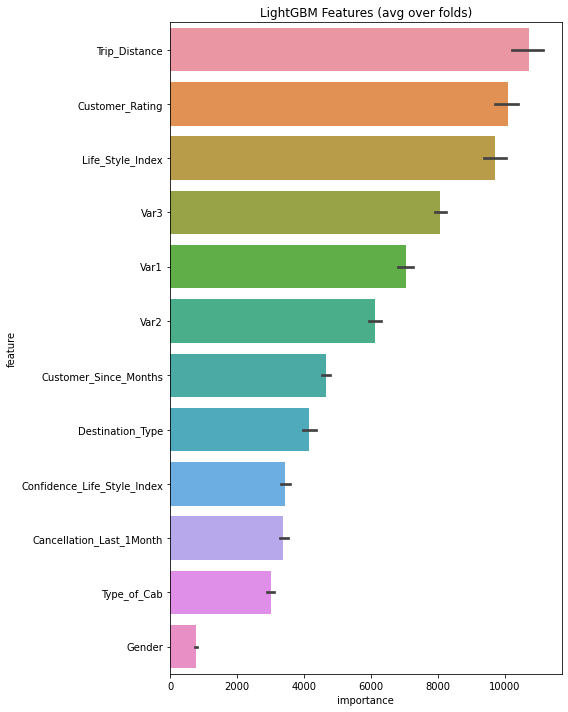

In [42]:
allmodelstart= time.time()
# Run Model with different Seeds
multi_seed_pred = dict()
all_feature_importance_df  = pd.DataFrame()

# To submit each seed model seperately aswell
def seed_submit(model,seed):
    # Output position with highest probability
    class_prediction = (pd.DataFrame(model.predict(test_df)).idxmax(axis=1) + 1).rename(target_var)
    class_prediction.index = test_df.index

    # Submit
    class_prediction.to_csv('mean_seed{}_sub_ep{}_sc{}.csv'.format(seed,optimal_rounds,round(best_cv_score,5))
                ,index = True, header=True)

all_seeds = [27,22,300,401]
for seeds_x in all_seeds:
    modelstart= time.time()
    print("Seed: ", seeds_x,)
    # Go Go Go
    final_model_params["seed"] = seeds_x
    lgb_final = lgb.train(
        final_model_params,
        lgtrain,
        num_boost_round = optimal_rounds + 1,
        verbose_eval=200)

    # Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X.columns
    fold_importance_df["importance"] = lgb_final.feature_importance()
    all_feature_importance_df = pd.concat([all_feature_importance_df, fold_importance_df], axis=0)

    multi_seed_pred[seeds_x] =  pd.DataFrame(lgb_final.predict(test_df))
    # Submit Model Individually
    seed_submit(model= lgb_final, seed= seeds_x)
    print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
    print("###########################################################################################")
    del lgb_final

cols = all_feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index
best_features = all_feature_importance_df.loc[all_feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", 
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgb_finalm_importances.png')
print("All Model Runtime: %0.2f Minutes"%((time.time() - allmodelstart)/60))

## Getting the average resulsts based on seeds

In [43]:
# Collapse Seed DataFrames
panel = pd.Panel(multi_seed_pred)
print("Seed Effect Breakdown: Classwise Statistics")
for i,(std,mean) in enumerate(zip(panel.std(axis=0).mean(axis=0),panel.mean(axis=0).mean(axis=0))):
    print("Class {}:".format(i+1))
    print("Mean {0:.3f} (+/-) {1:.5f}\n".format(mean,std))

Seed Effect Breakdown: Classwise Statistics
Class 1:
Mean 0.000 (+/-) 0.00000

Class 2:
Mean 0.206 (+/-) 0.00458

Class 3:
Mean 0.429 (+/-) 0.00701

Class 4:
Mean 0.366 (+/-) 0.00660



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [44]:
# Take Mean over Seed prediction
mean_prob = panel.mean(axis=0)
class_prediction = pd.DataFrame()
class_prediction["Trip_Id"] = sample_df["Trip_ID"]
# Output position with highest probability
class_prediction["Surge_Pricing_Type"] = mean_prob.idxmax(axis=1) 
#class_prediction.rename(target_var,inplace=True)


# Submit
class_prediction.to_csv('mean_sub_ep{}_sc{}.csv'.format(optimal_rounds,round(best_cv_score,5))
            ,index = True, header=True)
# Save Results..
results.to_csv("model_tuning_results.csv")
class_prediction.head()

,Trip_Id,Surge_Pricing_Type
0,T0005689459,1
1,T0005689462,2
2,T0005689463,2
3,T0005689466,2
4,T0005689468,2


In [0]:
sample_df["Surge_Pricing_Type"] = mean_prob.idxmax(axis=1) 

In [0]:
sample_df.to_csv("sample.csv",index=False)

## Submitting seed results

In [0]:
#m1 = pd.read_csv("/content/mean_seed27_sub_ep604_sc0.2939.csv")
#m2 = pd.read_csv("/content/mean_seed22_sub_ep604_sc0.2939.csv")
#m3 = pd.read_csv("/content/mean_seed300_sub_ep604_sc0.2939.csv")
#m4 = pd.read_csv("/content/mean_seed401_sub_ep604_sc0.2939.csv")
#m5 = pd.read_csv("/content/mean_sub_ep604_sc0.2939.csv")

In [0]:
#m1["Surge_Pricing_Type"]=m1["Surge_Pricing_Type"]-1
#m1["Unnamed: 0"] = sample_df["Trip_ID"]
#m2["Surge_Pricing_Type"]=m2["Surge_Pricing_Type"]-1
#m2["Unnamed: 0"] = sample_df["Trip_ID"]
#m3["Surge_Pricing_Type"]=m3["Surge_Pricing_Type"]-1
#m3["Unnamed: 0"] = sample_df["Trip_ID"]
#m4["Surge_Pricing_Type"]=m4["Surge_Pricing_Type"]-1
#m4["Unnamed: 0"] = sample_df["Trip_ID"]
#m5["Surge_Pricing_Type"]=m5["Surge_Pricing_Type"]
#m1=m1.drop(["Unnamed: 0"],axis=1)
#m2=m2.drop(["Unnamed: 0"],axis=1)
#m3=m3.drop(["Unnamed: 0"],axis=1)
#m4=m4.drop(["Unnamed: 0"],axis=1)
#m5=m5.drop(["Unnamed: 0"],axis=1)
                                            

In [0]:
#m1.columns = ["Trip_ID", "Surge_Pricing_Type"]
#m2.columns = ["Trip_ID", "Surge_Pricing_Type"]
#m3.columns = ["Trip_ID", "Surge_Pricing_Type"]
#m4.columns = ["Trip_ID", "Surge_Pricing_Type"]
#m5.columns = ["Trip_ID", "Surge_Pricing_Type"]

In [0]:
#m1.to_csv("mean_seed27.csv",index=False)
#m2.to_csv("mean_seed22.csv",index=False)
#m3.to_csv("mean_seed300.csv",index=False)
#m4.to_csv("mean_seed401.csv",index=False)
#m5.to_csv("mean_seed604.csv",index=False)